# Fraudulant credit card transactions
This interactive notebook will present some basic machine learning techniques using an unbalanced data set of credit card transactions found on [Kaggle.com](https://www.kaggle.com/mlg-ulb/creditcardfraud). The data is labeled according to whether or not the transaction is fraudulant.

### Importing the data
Import the data from `creditcard.csv`. Features include V1 through V28 as well as `Amount`, which is 
the amount of the transaction and `Time`, which is the elapsed time since recording when the transaction occurred. Each row corresponds to a credit card transaction. The target is stored in the `Class` column, where a value of 1 corresponds to an instance of fraud and 0 corresponds to 
an instance of not fraud.

Here will import the data into a Pandas dataframe and then compute the percentage of fraudulant transactions. Since there are so many example transactions, we'll only look at a sample of 10% of the data.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('creditcard.csv')
df = df.sample(frac = 0.1, axis = 0, random_state = 0)

percent_fraudulent = df['Class'].mean()
percent_fraudulent

0.0019311119693830976

### Dummy classifier
Since the percentage of fraudulant transactions is so low, using accuracy as a metric for any classifier would not give an accurate assesment of how good our algorithm is at classifying fraudulant transactions. 

To illustrate this, we split the data into training and testing samples and compute the accuracy and recall.

In [3]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,1:-1] #we will not be using the Time feature
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score

dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train,y_train)
dummy_predictions = dummy_majority.predict(X_test)

( dummy_majority.score(X_test,y_test), recall_score(y_test,dummy_predictions) )

(0.9984552731357955, 0.0)

### SVC Classifier
Even though the accuracy of our dummy classifier is nearly one, the recall score shows that it's not good at identifying fraudulant transactions.

We will now train a support vector classifier using the default parameters and compute the accuracy and recall of this classifier.

In [9]:
from sklearn.metrics import recall_score, precision_score
from sklearn.svm import SVC

svm = SVC(gamma = 'scale').fit(X_train,y_train)
svm_predict = svm.predict(X_test)


    
( svm.score(X_test,y_test), recall_score(y_test, svm_predict) )

(0.9984552731357955, 0.0)

### (A better) SVC Classifier
Even though the accuracy of our support vector machine classifier is nearly one, the recall score shows that it's not good at identifying fraudulant transactions.

We will now use an SVC with parameters {'C': 1e9, 'gamma': 1e-07}. We will output the confusion matrix when using a threshold of -220 on the decision function with `X_test` and `y_test`.

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

svm = SVC(C = 1e9, gamma = 1e-07).fit(X_train,y_train)
y_scores = svm.decision_function(X_test)
y_predict = svm.predict(X_test)


threshold_y_scores = 1-(y_scores<-220*1)
confusion = confusion_matrix(y_test, threshold_y_scores)
print(confusion)

[[6919  191]
 [   1   10]]


We see that there were 191 false positives, 1 false negative, and 10 true positives when using -220 as a threshold for the decision function.

### Logistic classifier

Now we'll train a logistic classifier with default parameters using X_train and y_train. For this classifier, we'll plot the precision recall curve and an roc curve using `y_test` and the probability estimates for
`X_test` (i.e. the probability the transaction is fraudulant). 

<IPython.core.display.Javascript object>


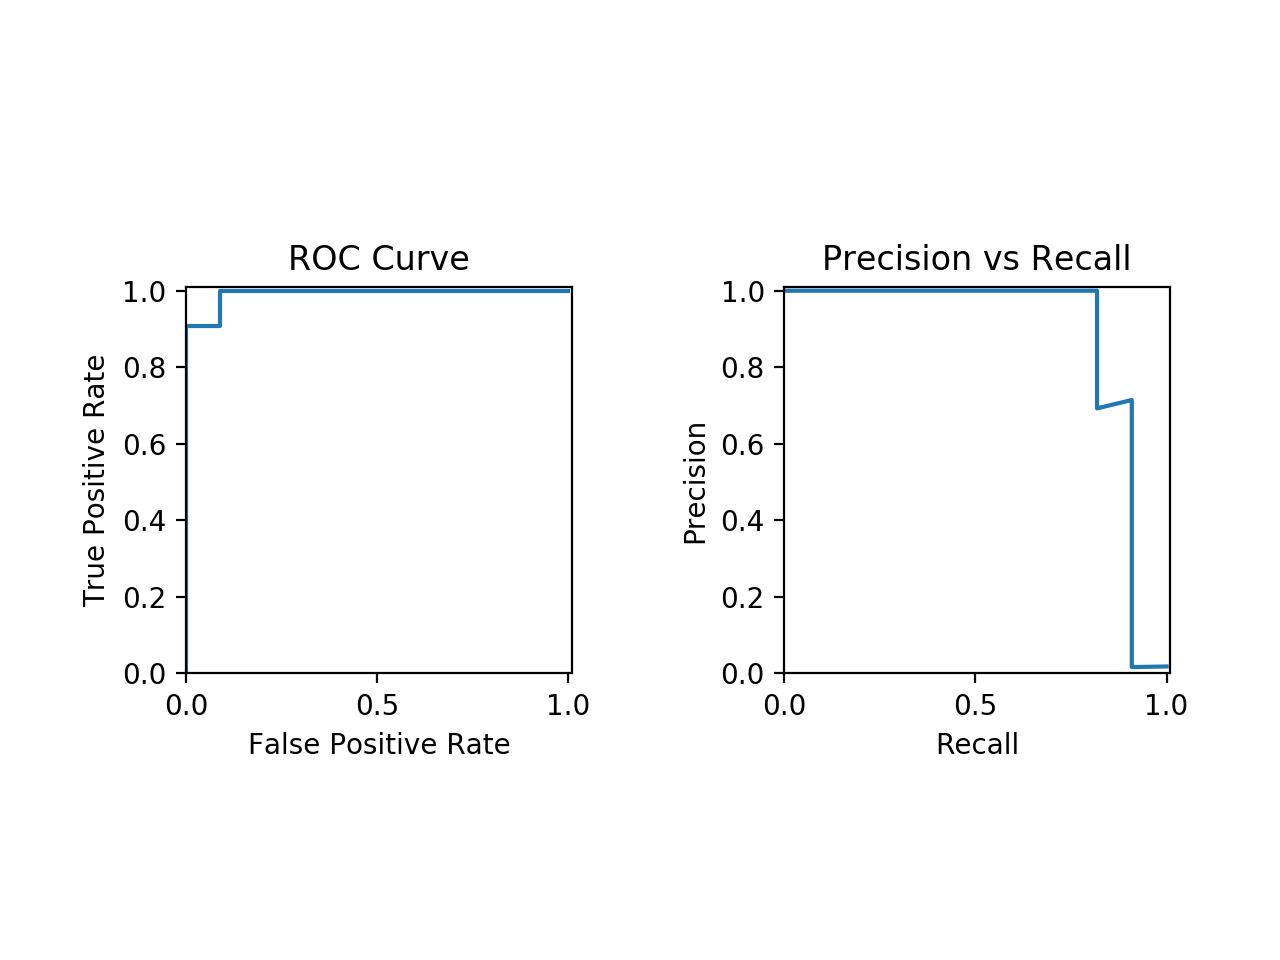

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve

lr = LogisticRegression(solver = 'liblinear').fit(X_train, y_train)
lr_score = lr.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, lr_score)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_score)


fig,a =  plt.subplots(1,2)
a[0].plot(fpr_lr, tpr_lr, label='roc_curve')
a[0].set_xlim([0.0, 1.01])
a[0].set_ylim([0.0, 1.01])
a[0].set_title('ROC Curve')
a[0].set_xlabel('False Positive Rate')
a[0].set_ylabel('True Positive Rate')
a[0].set_aspect('equal')

a[1].plot(recall, precision, label='Precision-Recall_curve')
a[1].set_xlim([0.0, 1.01])
a[1].set_ylim([0.0, 1.01])
a[1].set_title('Precision vs Recall')
a[1].set_xlabel('Recall')
a[1].set_ylabel('Precision')
a[1].set_aspect('equal')
fig.tight_layout(pad=3.0)
plt.show()


### Fine Tuning:
Now we'll perform a grid search over the parameters listed below for a Logistic Regression classifier using recall for scoring and
the default 3-fold cross validation. {'penalty': ['l1','l2'],'C' : [0.01, 0.1, 1, 10, 100]}. We'll organize the results by creating an
array of the mean test scores of each parameter combination.

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid_values = {'penalty': ['l1','l2'], 'C': [0.01, 0.1, 1, 10, 100]}
lr = LogisticRegression(solver = 'liblinear', max_iter=500)
grid_lr_recall = GridSearchCV(lr, param_grid = grid_values, scoring = 'recall', cv = 3)
grid_lr_recall.fit(X_train,y_train)
grid_data = pd.DataFrame(grid_lr_recall.cv_results_)
mean_test_scores = grid_data.set_index('params')['mean_test_score']

print(mean_test_scores.values.reshape(5,2))

[[0.15714888 0.51904963]
 [0.51746879 0.53969413]
 [0.58573502 0.58572878]
 [0.53970662 0.5397035 ]
 [0.53970662 0.53970662]]


Therefore, an $L_1$-penalty with a $C$-value of 1 appears to yield the best combination of parameters for the Logistic Regression classifier.